<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/MultiLabel_efficientnet_b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [ ]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [30]:
!pip install wwf -q

Importamos las librerías necesarias:

In [32]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import * 

In [33]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [ ]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [ ]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [7]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [8]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def crearDataFrame(df, nombreConjunto):
  columnas = list(df.columns)[2:]
  df = df.reset_index(drop=True) #Elimino la columna index con drop=True

  nombres = [] #nombre de las imagenes
  enfermedades = [] #nombres de las enfermedades

  for i in df.index:
    cadena = ''
    nombres.append(nombreConjunto + str(df['ID'][i]))
    if df['Disease_Risk'][i] == 1:
      for x in columnas:
        if(df[x][i]==1):
          cadena += cadena + ' ' + x
    else:
      cadena = ' NORMAL'
    enfermedades.append(cadena[1:])
  data = {'nombre_img': nombres,
        'tags': enfermedades
        }
  return pd.DataFrame(data)

In [10]:
df_train_ML = crearDataFrame(df_train, str(trainPath) + '/Training/')
df_test_ML = crearDataFrame(df_test, str(testPath) + '/Test/')
df_val_ML = crearDataFrame(df_val, str(valPath) + '/Validation/')

In [11]:
df_train_ML.head(10)

,nombre_img,tags
0,Training_Set_Pre/Training/1,DR
1,Training_Set_Pre/Training/2,DR
2,Training_Set_Pre/Training/3,DR
3,Training_Set_Pre/Training/4,MH MH ODC
4,Training_Set_Pre/Training/5,DR DR LS
5,Training_Set_Pre/Training/6,ARMD ARMD MYA
6,Training_Set_Pre/Training/7,ARMD ARMD MYA
7,Training_Set_Pre/Training/8,ARMD ARMD MYA
8,Training_Set_Pre/Training/9,ERM
9,Training_Set_Pre/Training/10,NORMAL


In [12]:
df_train_ML['is_valid'] = False
df_val_ML['is_valid'] = True

In [13]:
df_train_val = pd.concat([df_train_ML, df_val_ML])

In [14]:
df_train_val

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH MH ODC,False
4,Training_Set_Pre/Training/5,DR DR LS,False
...,...,...,...
635,Evaluation_Set_Pre/Validation/636,TSLN,True
636,Evaluation_Set_Pre/Validation/637,TSLN,True
637,Evaluation_Set_Pre/Validation/638,NORMAL,True
638,Evaluation_Set_Pre/Validation/639,NORMAL,True


In [15]:
# df_train_val[df_train_val['nombre_img']=='val/640']['is_valid'].values[0]

In [16]:
def conjuntoImg(nombreImg):
  return True if df[df['nombre_img'] == nombreImg[0]]['is_valid'].values[0] else False

In [17]:
df = df_train_val

In [18]:
conjuntoImg(['Training_Set_Pre/Training/503','ODP', True])

False

## Datablock

In [19]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [20]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=FuncSplitter(conjuntoImg),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [21]:
dls = db.dataloaders(df.values)

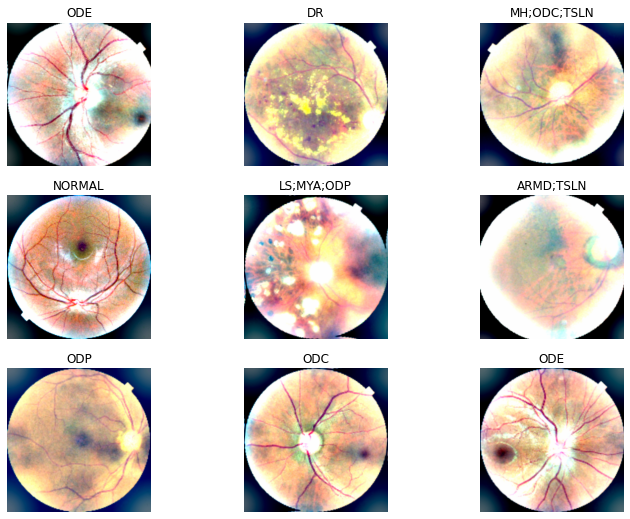

In [22]:
dls.show_batch(max_n=9, figsize=(12,9))

## Entrenar Modelo

In [23]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')
]

In [28]:
import timm

In [34]:
learn = timm_learner(dls, 'efficientnet_b3', pretrained=True, metrics=[accuracy_multi], cbs=callbacks)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [35]:
learn.lr_find(suggest_funcs=(minimum, steep))

RuntimeError: ignored

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.801937,0.210604,0.948222,00:09


Better model found at epoch 0 with valid_loss value: 0.21060366928577423.


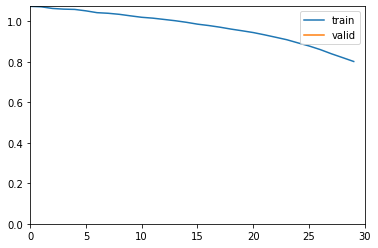

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.218342,0.141376,0.962554,00:10
1,0.168789,0.113738,0.965787,00:09
2,0.140730,0.109965,0.966595,00:10
3,0.122168,0.106256,0.966056,00:10
4,0.107870,0.102903,0.966649,00:10
5,0.098203,0.109735,0.964817,00:10
6,0.090667,0.112214,0.964224,00:11
7,0.084901,0.108523,0.966433,00:10
8,0.079851,0.110913,0.967134,00:10
9,0.075595,0.116330,0.966056,00:10


Better model found at epoch 0 with valid_loss value: 0.14137570559978485.


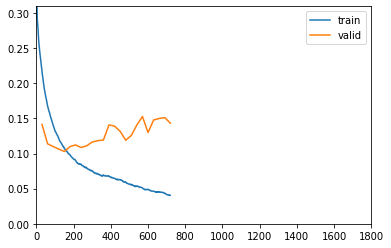

Better model found at epoch 1 with valid_loss value: 0.1137378066778183.
Better model found at epoch 2 with valid_loss value: 0.10996481031179428.
Better model found at epoch 3 with valid_loss value: 0.10625608265399933.
Better model found at epoch 4 with valid_loss value: 0.10290271043777466.
No improvement since epoch 4: early stopping


In [285]:
learn.fine_tune(60,base_lr=1e-2)

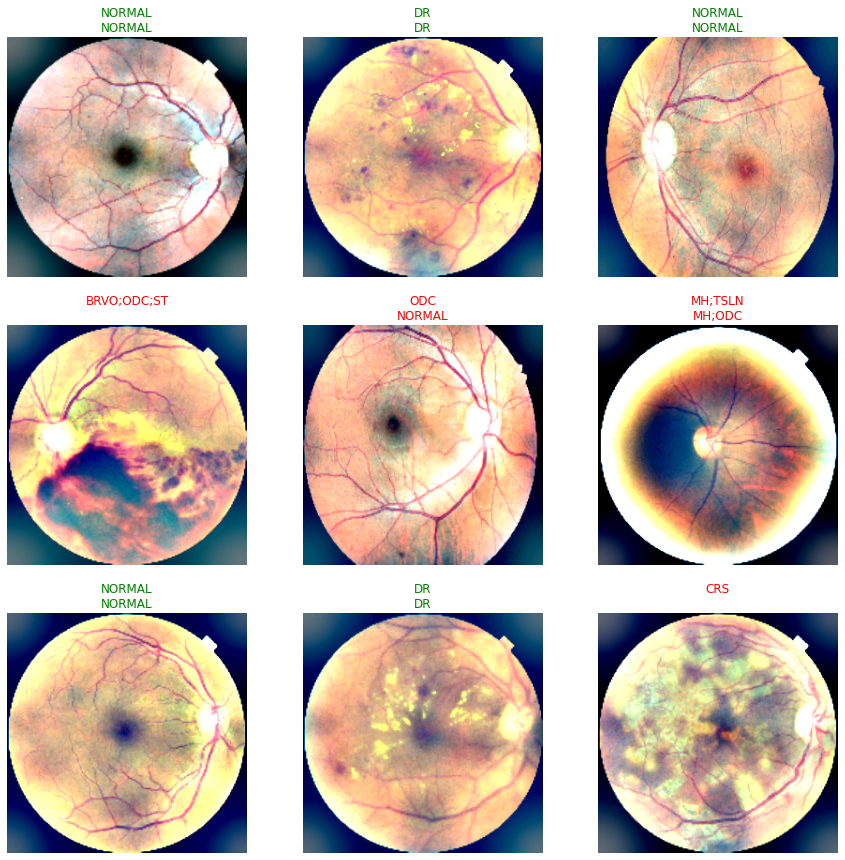

In [286]:
learn.show_results(figsize=(15,15))

## Evaluar el modelo

In [290]:
dbTest = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [291]:
dlsTest = dbTest.dataloaders(df_test_ML)

In [292]:
learn.dls = dlsTest

In [293]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9361530542373657.


(#2) [0.3812965154647827,0.9361530542373657]

Exportamos el modelo

In [296]:
learn.to_fp32()
learn.export('MultiLabel_efficientnet_b3.pkl')

## Comprobaciones manuales

In [298]:
learn_inf = load_learner('MultiLabel_efficientnet_b3.pkl')

In [312]:
df_test[df_test['Disease_Risk']==0]
# df_test.iloc[0:20,:]

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
244,245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625,626,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
627,628,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [324]:
learn_inf.predict('Test_Set_Pre/Test/272.png')[0]

(#1) ['ODE']

In [322]:
learn_inf.predict('Test_Set_Pre/Test/623.png')[0]

(#1) ['NORMAL']

In [323]:
learn_inf.predict('Test_Set_Pre/Test/626.png')[0]

(#1) ['NORMAL']

In [320]:
learn_inf.predict('Test_Set_Pre/Test/628.png')[0]

(#1) ['NORMAL']

In [321]:
learn_inf.predict('Test_Set_Pre/Test/629.png')[0]

(#1) ['NORMAL']